# "Backtesting with your own custom strategy"
> "Write your own buy and sell signals from custom indicators and built-in indicators"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Benj Del Mundo
- categories: [backtest, custom strategy]

# Overview

In this example, we will
1. Create a new indicator outside fastquant (this could be anything from time-series methods to machine-learning-based methods)
2. Combine our new indicator with some built-in indicators in our strategy
3. Use multiple conditions on buy and sell signals

In [1]:
# uncomment to install in colab
# !pip3 install fastquant

In [2]:
from fastquant import backtest,get_stock_data
import numpy as np

In [3]:
df = get_stock_data("AAPL",start_date='2019-01-01',end_date='2019-06-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,open,high,low,close,volume
dt,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,140014000
2019-01-02,38.722500,39.712502,38.557499,39.480000,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,219111200


### Create our own custom indicator. In this case, we'll use scipy implementation of Arnaud Legoux Moving Average (ALMA)

> Arnaud Legoux Moving Average (ALMA) removes small price fluctuations and enhances the trend by applying a moving average twice, once from left to right, and once from right to left. At the end of this process the phase shift (price lag) commonly associated with moving averages is significantly reduced

(https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/arnaudlegoux.htm)


In [5]:
from scipy.ndimage import convolve1d as conv

def alma_indicator(data,window=9,offset=0.85,sigma=6):
    m = int(offset * window-1)
    s = window/sigma
    dss = 2*s*s
    wtds = np.exp(-(np.arange(window) - m)**2/dss)
    return conv(data, weights=wtds/wtds.sum(),axis=0, mode='nearest')

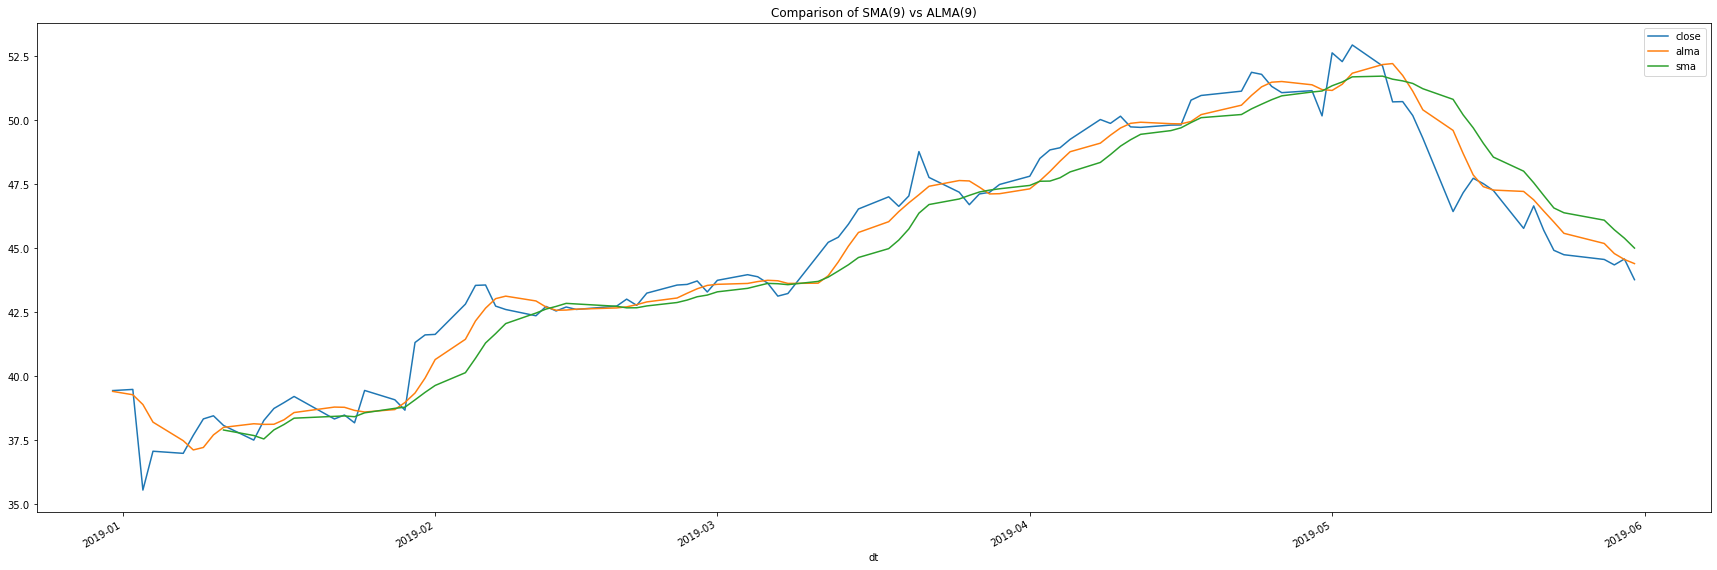

In [6]:
%matplotlib inline
df["alma"] = alma_indicator(df.close, window=9,offset=0.85,sigma=6)
df["sma"] = df.close.rolling(9).mean()


df[["close","alma","sma"]].plot(figsize=(30,10),title="Comparison of SMA(9) vs ALMA(9)")

In [7]:
df.head()

,open,high,low,close,volume,alma,sma
dt,,,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,140014000,39.403000,NaN
2019-01-02,38.722500,39.712502,38.557499,39.480000,148158800,39.272023,NaN
2019-01-03,35.994999,36.430000,35.500000,35.547501,365248800,38.889287,NaN
2019-01-04,36.132500,37.137501,35.950001,37.064999,234428400,38.202014,NaN
2019-01-07,37.174999,37.207500,36.474998,36.982498,219111200,37.477802,NaN


## Implementing our custom strategy

In this strategy we will have the following signals:

Buy on:
- Closing price is above ALMA
- MACD crosses above the MACD signal line

Sell on:
- Closing price falls below ALMA

In [8]:
from fastquant import CustomStrategy, BaseStrategy
from fastquant.indicators import MACD, CrossOver, CustomIndicator


# Create a subclass of the BaseStrategy, We call this MAMAStrategy (MACD + ALMA)
class MAMAStrategy(BaseStrategy):
    
    params = (
        ("alma_column", "alma"),   # name for the ALMA column from the dataframe
        ("macd_fast_period", 12),  # period for the MACD
        ("macd_slow_period", 16),
        ("macd_signal_period",9)
    )

    def __init__(self):
        # Initialize global variables
        super().__init__()
        
        # Setup MACD indicator parameters
        self.macd_fast_period = self.params.macd_fast_period
        self.macd_slow_period = self.params.macd_slow_period
        self.macd_signal_period = self.params.macd_signal_period
       
        
        # Setup MACD indicator, macd line and macd signal line, and macd signal line crossover
        self.macd_ind = MACD(
            period_me1=self.macd_fast_period, 
            period_me2=self.macd_slow_period, 
            period_signal=self.macd_signal_period
        )
        self.macd = self.macd_ind.macd
        self.macd_signal = self.macd_ind.signal
        
        # Add signal line cross over
        self.macd_signal_crossover = CrossOver(
            self.macd_ind, self.macd_signal
        )
        
        # Assign ALMA column from the dataframe
        self.alma_column = self.params.alma_column
        
        # Set ALMA indicator from the alma column of data
        self.alma = CustomIndicator(
            self.data, custom_column=self.alma_column,
        )
        
        # Plot the ALMA indicator along with the price instead of a separate plot
        self.alma.plotinfo.subplot=False


        print("===Strategy level arguments===")
        print("PARAMS: ", self.params)
        

    # Buy when the custom indicator is below the lower limit, and sell when it's above the upper limit
    def buy_signal(self):
        alma_buy =  self.dataclose[0] > self.alma[0]    # Close is above ALMA
        macd_buy = self.macd_signal_crossover > 0       # MACD crosses signal line upward
        
        
        return alma_buy and macd_buy 
    def sell_signal(self):
        return self.alma[0] > self.dataclose[0]


===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
commission : 0.0075
stop_loss : None
stop_trail : None
===Strategy level arguments===
PARAMS:  <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BaseStrategy_MAMAStrategy object at 0x7faea068b710>
Final Portfolio Value: 93388.75828515051
Final PnL: -6611.24
Time used (seconds): 0.0692756175994873
Optimal parameters: {'init_cash': 100000, 'buy_prop': 1, 'sell_prop': 1, 'commission': 0.0075, 'stop_loss': None, 'stop_trail': None, 'execution_type': 'close', 'channel': None, 'symbol': None, 'allow_short': False, 'short_max': 1.5, 'add_cash_amount': None, 'add_cash_freq': 'M', 'alma_column': 'alma', 'macd_fast_period': 12, 'macd_slow_period': 16, 'macd_signal_period': 9}
Optimal metrics: {'rtot': -0.06839920896995008, 'ravg': -0.0006514210378090484, 'rnorm': -0.15139215492317035, 'rnorm100': -15.139215492317035, 'len': 49, 'drawdown': 12.74288298220236

<IPython.core.display.Javascript object>


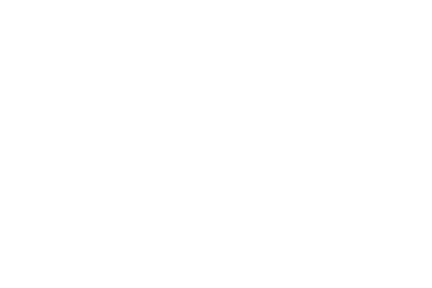

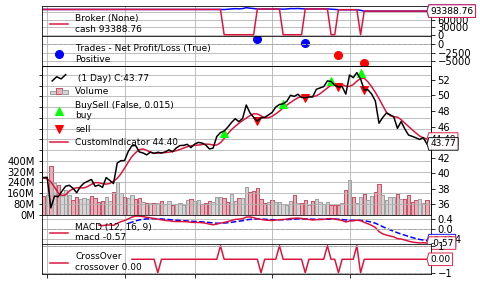

In [9]:
%matplotlib inline
result, history = backtest(MAMAStrategy,df, verbose=False, return_history=True)
# result

In [10]:
result

,strat_id,init_cash,buy_prop,sell_prop,commission,stop_loss,stop_trail,execution_type,channel,symbol,...,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value
0,0,100000,1,1,0.0075,None,None,close,None,None,...,-15.139215,49,12.742883,13638.337586,"{'len': 49, 'drawdown': 12.742882982202364, 'm...",12.742883,49,-1.302515,-6611.24,93388.758285


In [11]:
history['orders']

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,,2019-03-13,buy,45.227501,2192,99138.682007,743.540115,0.000000
1,0,,2019-03-26,sell,46.697498,-2192,99138.682007,767.706872,3222.234314
2,0,,2019-04-04,buy,48.837502,2065,100849.440651,756.370805,0.000000
3,0,,2019-04-12,sell,49.717499,-2065,100849.440651,769.999762,1817.194328
4,0,,2019-04-24,buy,51.869999,1949,101094.627918,758.209709,0.000000
5,0,,2019-04-26,sell,51.075001,-1949,101094.627918,746.588824,-1549.451431
6,0,,2019-05-06,buy,52.937500,1853,98093.187500,735.698906,0.000000
7,0,,2019-05-07,sell,50.715000,-1853,98093.187500,704.811715,-4118.292217
